<a href="https://colab.research.google.com/github/aoctavia/Spin-Glass-Ground-State-via-Graph-RL-GNN/blob/main/Spin_Glass_Ground_State_via_Graph_RL_%2B_GNN_(Bridge_ke_Combinatorial_Optimization).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Spin-Glass Ground State via Graph RL + GNN (Bridge ke Combinatorial Optimization)

Ide ringkas: Pecahkan ground state spin glass (±J) pada graf 2D/acak sebagai Max-Cut; gabungkan policy gradient RL (atau Q-learning) dengan GNN sebagai representasi kebijakan.
Mengapa “wah”: Menghubungkan many-body ↔ NP-hard optimization secara eksplisit.
Komponen teknis:

1. Formulasi energi Ising sebagai cut cost; reward = −energy.

2. GNN policy (SAGEConv/GIN) yang meng-assign spin; curriculum dari graf kecil ke besar.

3. Bandingkan dengan: Simulated Annealing, ILP (ukuran kecil), dan QAOA klasik (simulasi) untuk benchmark.
Evaluasi:

4. Gap ke optimum (ILP) pada n≤128.

5. Skala waktu vs kualitas solusi; generalization ke topologi/graf unseen.
Deliverables:

6. Repo dengan benchmarks reproducible, tabel hasil lawan annealing/QAOA.

7. Poster 1 halaman: grafik gap vs ukuran graf.
Stack: PyTorch Geometric + OR-Tools (untuk ILP kecil) + PennyLane/qiskit (simulasi QAOA, opsional).

Cell 1 — Setup & Installs (Colab)

In [13]:
# If running on Colab: install deps
!pip -q install numpy scipy matplotlib seaborn networkx tqdm einops ortools

# (Colab biasanya sudah punya torch)
import torch, sys, subprocess
ver = torch.__version__.split('+')[0]

# --- PyTorch Geometric (CPU wheels; paling aman & kompatibel) ---
pyg_url = f"https://data.pyg.org/whl/torch-{ver}+cpu.html"
subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q',
                       'pyg_lib', 'torch_scatter', 'torch_sparse', 'torch_cluster', 'torch_spline_conv',
                       '-f', pyg_url])
subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', 'torch_geometric'])

print("Installed. Torch:", torch.__version__)


Installed. Torch: 2.8.0+cu126


Cell 2 — Imports, Config, Reproducibility

In [14]:
import os, math, random, time, json
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import torch
from torch import nn
from torch.distributions import Categorical

from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, GINConv, global_mean_pool

# Reproducibility
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", DEVICE)

# Master config (bisa diubah)
CFG = {
    # training graphs (curriculum sizes)
    "train_graph_type": "er",      # "er" | "grid" | "reg3"
    "train_sizes": [30, 40, 50],   # curriculum sizes
    "train_p": 0.20,               # ER edge probability
    "episodes_per_epoch": 60,      # graphs per epoch
    "epochs": 30,

    # RL
    "gamma": 1.0,                  # episodic, reward shaping
    "lr": 3e-4,
    "hidden": 128,
    "gcn_layers": 3,
    "dropout": 0.1,
    "entropy_coef": 0.01,
    "value_coef": 0.5,
    "grad_clip": 1.0,

    # evaluation
    "eval_small_n": 22,            # small graphs for ILP
    "eval_small_p": 0.25,
    "ilp_time_limit_s": 10,
    "eval_large_n": 80,            # larger graphs (SA vs RL)
    "eval_large_p": 0.15,

    # node order during construction
    "node_order": "degree",        # "degree" | "random"
}

sns.set_style("whitegrid")
print(json.dumps(CFG, indent=2))


Device: cpu
{
  "train_graph_type": "er",
  "train_sizes": [
    30,
    40,
    50
  ],
  "train_p": 0.2,
  "episodes_per_epoch": 60,
  "epochs": 30,
  "gamma": 1.0,
  "lr": 0.0003,
  "hidden": 128,
  "gcn_layers": 3,
  "dropout": 0.1,
  "entropy_coef": 0.01,
  "value_coef": 0.5,
  "grad_clip": 1.0,
  "eval_small_n": 22,
  "eval_small_p": 0.25,
  "ilp_time_limit_s": 10,
  "eval_large_n": 80,
  "eval_large_p": 0.15,
  "node_order": "degree"
}


Cell 3 — Graph Generators (ER, Grid, 3‑Regular) + Spin‑Glass Couplings

In [15]:
def make_er_graph(n=40, p=0.2, seed=None):
    rng = np.random.RandomState(seed)
    G = nx.erdos_renyi_graph(n, p, seed=seed)
    # pastikan ada edge
    while G.number_of_edges() == 0:
        G = nx.erdos_renyi_graph(n, p, seed=int(rng.randint(1e9)))
    # ambil komponen terbesar agar tidak ada isolated
    if not nx.is_connected(G):
        comp = max(nx.connected_components(G), key=len)
        G = G.subgraph(comp).copy()
        # relabel ke 0..N-1 setelah ambil komponen terbesar
        mapping = {old:i for i,old in enumerate(G.nodes())}
        G = nx.relabel_nodes(G, mapping, copy=True)

    # assign J ∈ {-1,+1}
    for u, v in G.edges():
        G[u][v]['J'] = 1 if rng.rand() < 0.5 else -1
    return G


def make_grid_graph(L=6, periodic=False, seed=None):
    # 2D grid LxL
    G = nx.grid_2d_graph(L, L, periodic=periodic)
    mapping = {xy:i for i,xy in enumerate(G.nodes())}
    G = nx.relabel_nodes(G, mapping, copy=True)
    rng = np.random.RandomState(seed)
    for u, v in G.edges():
        G[u][v]['J'] = 1 if rng.rand() < 0.5 else -1
    return G

def make_reg_k_graph(n=40, k=3, seed=None):
    rng = np.random.RandomState(seed)
    # might fail if (n*k) odd; adjust
    if (n * k) % 2 == 1:
        n += 1
    G = nx.random_regular_graph(k, n, seed=seed)
    for u, v in G.edges():
        G[u][v]['J'] = 1 if rng.rand() < 0.5 else -1
    return G

def undirected_edges_with_J(G):
    edges = []
    for u, v, data in G.edges(data=True):
        J = data.get('J', 1)
        if u < v: edges.append((u, v, J))
        else:     edges.append((v, u, J))
    edges = list({(min(u,v), max(u,v), J) for (u,v,J) in edges})
    return edges


Cell 4 — Convert to PyG Data (features + edge weights) & Energy Functions

In [16]:
def to_pyg_data(G):
    edges = undirected_edges_with_J(G)
    n = G.number_of_nodes()
    # Build directed edge_index & edge_weight (use J as weight)
    edge_index = []
    edge_weight = []
    for (u,v,J) in edges:
        edge_index.append([u,v]); edge_index.append([v,u])
        edge_weight.append(J);     edge_weight.append(J)
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_weight = torch.tensor(edge_weight, dtype=torch.float32)

    # Node features: [assigned_flag, spin_value, degree]
    x = torch.zeros(n, 3, dtype=torch.float32)
    deg = torch.tensor([G.degree[i] for i in range(n)], dtype=torch.float32)
    x[:, 2] = deg

    data = Data(x=x, edge_index=edge_index, edge_weight=edge_weight, num_nodes=n)
    data.edge_list_undirected = edges  # keep for exact energy calc
    return data

def energy_from_spins(edge_list, spins):
    # H = - sum_{(i,j)} J_ij s_i s_j, s_i ∈ {-1,+1}
    H = 0.0
    for (u,v,J) in edge_list:
        H += - J * spins[u] * spins[v]
    return float(H)

def delta_energy_for_assignment(edge_list, partial_spins, node, spin_value):
    # incremental dH contributed oleh edges yang incident ke 'node'
    dH = 0.0
    for (u,v,J) in edge_list:
        if u == node and v in partial_spins:
            dH += - J * spin_value * partial_spins[v]
        elif v == node and u in partial_spins:
            dH += - J * spin_value * partial_spins[u]
    return dH


In [17]:
# --- PyG graph preprocessing: add self-loops & coalesce ---
from torch_geometric.utils import add_self_loops, coalesce

def preprocess_pyg(data: Data, fill_value: float = 1.0) -> Data:
    """
    Tambah self-loop agar derajat node minimal 1 (hindari 0/0 pada normalisasi GCN),
    lalu coalesce (merge multi-edges) sambil menjumlahkan bobot edge.
    Kompatibel dgn PyG: coalesce(edge_index, edge_attr, num_nodes=None, reduce='add').
    """
    # Tambah self-loops (isi bobot self-loop = fill_value)
    ei, ew = add_self_loops(
        data.edge_index, data.edge_weight,
        num_nodes=data.num_nodes, fill_value=fill_value
    )
    # Gabungkan multi-edges; jumlahkan bobotnya
    ei, ew = coalesce(ei, ew, num_nodes=data.num_nodes, reduce='add')

    data.edge_index = ei
    data.edge_weight = ew

    # (opsional) sanity: pastikan tidak ada NaN/Inf
    if not torch.isfinite(data.edge_weight).all():
        raise RuntimeError("Found non-finite edge_weight after coalesce.")

    return data


# --- Override to_pyg_data: PANGGIL preprocess_pyg SEBELUM return ---
def to_pyg_data(G):
    edges = undirected_edges_with_J(G)
    n = G.number_of_nodes()

    # Directed edge_index & edge_weight (pakai J sebagai bobot)
    edge_index = []
    edge_weight = []
    for (u, v, J) in edges:
        edge_index.append([u, v]); edge_index.append([v, u])
        edge_weight.append(J);     edge_weight.append(J)
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_weight = torch.tensor(edge_weight, dtype=torch.float32)

    # Fitur node: [assigned_flag, spin_value, degree]
    x = torch.zeros(n, 3, dtype=torch.float32)
    deg = torch.tensor([G.degree[i] for i in range(n)], dtype=torch.float32)
    x[:, 2] = deg

    data = Data(x=x, edge_index=edge_index, edge_weight=edge_weight, num_nodes=n)
    # simpan juga daftar edge tak berarah untuk perhitungan energi persis
    data.edge_list_undirected = edges

    # ✅ langkah penting: tambahkan self-loops & coalesce
    data = preprocess_pyg(data, fill_value=1.0)
    return data

# --- (Opsional) sanity check cepat: pastikan logits finite untuk 1 instance ---
try:
    _tmp = generate_instance(CFG["train_graph_type"], n=CFG["train_sizes"][0], p=CFG["train_p"], seed=123).to(DEVICE)
    _env = SpinGlassEnv(_tmp, node_order=CFG["node_order"])
    node0 = _env.get_state()

    with torch.no_grad():
        _m = PolicyValueGNN(in_dim=3, hidden=CFG["hidden"], layers=CFG["gcn_layers"], dropout=CFG["dropout"]).to(DEVICE)
        _logits, _val = _m(_tmp, node0)
        print("Sanity logits finite? →", bool(torch.isfinite(_logits).all().item()), "| shape:", tuple(_logits.shape))
except Exception as e:
    print("Sanity check skipped:", e)


Sanity logits finite? → False | shape: (2,)


Cell 5 — EDA: Topology, Degree & Coupling Histograms

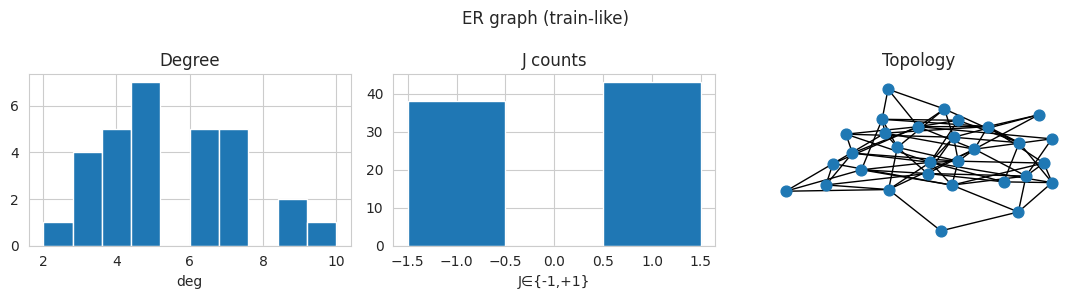

In [18]:
def eda_graph(G, title="EDA"):
    degrees = [d for _, d in G.degree()]
    Js = [G[u][v]['J'] for u, v in G.edges()]
    plt.figure(figsize=(11,3))
    plt.subplot(1,3,1); plt.hist(degrees, bins=10); plt.title("Degree"); plt.xlabel("deg")
    plt.subplot(1,3,2); plt.hist(Js, bins=[-1.5,-0.5,0.5,1.5]); plt.title("J counts"); plt.xlabel("J∈{-1,+1}")
    plt.subplot(1,3,3); nx.draw(G, node_size=60, with_labels=False); plt.title("Topology")
    plt.suptitle(title); plt.tight_layout(); plt.show()

G_demo = make_er_graph(n=CFG["train_sizes"][0], p=CFG["train_p"], seed=SEED)
eda_graph(G_demo, "ER graph (train-like)")


Cell 6 — Baseline: Simulated Annealing (SA)

In [19]:
def simulated_annealing(edge_list, n, steps=2500, T0=2.0, Tmin=0.01, alpha=0.995, seed=None):
    rng = np.random.RandomState(seed)
    spins = rng.choice([-1,1], size=n).astype(np.int8)

    # Precompute neighbours
    nbrs = [[] for _ in range(n)]
    for (u,v,J) in edge_list:
        nbrs[u].append((v,J))
        nbrs[v].append((u,J))

    def local_delta(i):
        s = spins[i]
        return 2.0 * s * sum(J * spins[j] for (j,J) in nbrs[i])

    H = energy_from_spins(edge_list, spins)
    best_spins = spins.copy(); best_H = H
    T = T0
    for _ in range(steps):
        i = rng.randint(0, n)
        dH = local_delta(i)
        if dH <= 0 or rng.rand() < math.exp(-dH/max(T,1e-8)):
            spins[i] = -spins[i]
            H += dH
            if H < best_H:
                best_H = H
                best_spins = spins.copy()
        T = max(Tmin, T * alpha)
    return best_spins, best_H

# smoke test
edges = undirected_edges_with_J(G_demo)
_, H_sa = simulated_annealing(edges, n=G_demo.number_of_nodes(), steps=1500, seed=0)
print("SA energy (demo):", H_sa)


SA energy (demo): -39.0


Cell 7 — Baseline: Exact ILP via CP‑SAT (Max‑Cut Mapping)

In [20]:
# ILP via OR-Tools CP-SAT: maximize Σ w_ij * z_ij  with z_ij = 1 if x_i != x_j.
# Mapping spin-glass: minimize H = -Σ J s_i s_j  == maximize Σ (-J) z_ij  (up to constant)
from ortools.sat.python import cp_model

def ilp_exact_maxcut_energy(edge_list, n, time_limit_s=10, workers=8):
    model = cp_model.CpModel()
    x = [model.NewBoolVar(f'x_{i}') for i in range(n)]
    z = {}
    w = {}

    for (u,v,J) in edge_list:
        key = (u,v)
        z[key] = model.NewBoolVar(f'z_{u}_{v}')
        w[key] = -int(J)  # weight = -J
        # XOR linearization
        model.Add(z[key] >= x[u] - x[v])
        model.Add(z[key] >= x[v] - x[u])
        model.Add(z[key] <= x[u] + x[v])
        model.Add(z[key] <= 2 - x[u] - x[v])

    # maximize Σ w z
    obj = sum(w[(u,v)] * z[(u,v)] for (u,v,_) in edge_list)
    model.Maximize(obj)

    solver = cp_model.CpSolver()
    solver.parameters.max_time_in_seconds = float(time_limit_s)
    solver.parameters.num_search_workers = workers
    status = solver.Solve(model)

    if status not in (cp_model.OPTIMAL, cp_model.FEASIBLE):
        return None, None, status

    # Recover z, compute H
    const_term = - sum(J for (_,_,J) in edge_list)
    sum_Jz = 0.0
    for (u,v,J) in edge_list:
        z_uv = solver.Value(z[(u,v)])
        sum_Jz += J * z_uv
    H = const_term + 2.0 * sum_Jz
    return float(H), solver.ObjectiveValue(), status

# smoke test (kecil)
G_small = make_er_graph(n=12, p=0.35, seed=7)
edges_small = undirected_edges_with_J(G_small)
H_opt, obj, status = ilp_exact_maxcut_energy(edges_small, n=G_small.number_of_nodes(), time_limit_s=5)
print("ILP small energy:", H_opt, "| status:", status)


ILP small energy: -18.0 | status: 4


Cell 8 — RL Environment (Construction by Node Assignment)

In [21]:
class SpinGlassEnv:
    """
    Episode = assign spins sequentially to all nodes.
    State features live in data.x: [assigned_flag, spin_value, degree]
    Action = choose spin {-1,+1} for current node.
    Reward shaping: r_t = -ΔH (so maximizing sum r_t minimizes final H).
    """
    def __init__(self, data: Data, node_order="degree"):
        self.data = data
        self.edge_list = data.edge_list_undirected
        self.n = data.num_nodes
        self.node_order_mode = node_order
        self.reset()

    def order_nodes(self):
        if self.node_order_mode == "degree":
            deg = self.data.x[:,2].cpu().numpy()
            order = list(np.argsort(-deg))  # high degree first
        elif self.node_order_mode == "random":
            order = list(range(self.n)); random.shuffle(order)
        else:
            order = list(range(self.n))
        return order

    def reset(self):
        self.partial_spins = {}
        self.t = 0
        self.order = self.order_nodes()
        # clear features (except degree)
        self.data.x[:,0] = 0.0
        self.data.x[:,1] = 0.0
        return self.get_state()

    def get_state(self):
        if self.t >= self.n:
            return None
        return self.order[self.t]

    def step(self, action_spin):
        node = self.order[self.t]
        dH = delta_energy_for_assignment(self.edge_list, self.partial_spins, node, action_spin)
        reward = -float(dH)
        # commit
        self.partial_spins[node] = int(action_spin)
        self.data.x[node,0] = 1.0
        self.data.x[node,1] = float(action_spin)
        self.t += 1
        done = (self.t == self.n)
        return self.get_state(), reward, done

    def final_energy(self):
        spins = np.ones(self.n, dtype=np.int8)
        for k, v in self.partial_spins.items():
            spins[k] = v
        return energy_from_spins(self.edge_list, spins), spins


Cell 9 — Policy‑Value GNN (A2C): GCN backbone + edge_weight = J

In [22]:
class PolicyValueGNN(nn.Module):
    """
    - Node features: [assigned_flag, spin_value, degree]
    - Edge weights: J in {-1,+1} (as 'edge_weight' for GCNConv).
    - Policy head: per-node logits for {-1,+1}; we query only the "current node" embedding.
    - Value head: graph-level V(s) via global mean pooling.
    """
    def __init__(self, in_dim=3, hidden=128, layers=3, dropout=0.1):
        super().__init__()
        self.convs = nn.ModuleList()
        self.convs.append(GCNConv(in_dim, hidden))
        for _ in range(layers-1):
            self.convs.append(GCNConv(hidden, hidden))
        self.dropout = nn.Dropout(dropout)

        self.policy_head = nn.Sequential(
            nn.Linear(hidden, hidden), nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(hidden, 2)  # logits for {-1,+1} -> index 0:-1, 1:+1
        )
        self.value_head = nn.Sequential(
            nn.Linear(hidden, hidden), nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(hidden, 1)
        )

    def embed(self, data: Data):
        x, edge_index, ew = data.x, data.edge_index, data.edge_weight
        h = x
        for conv in self.convs:
            h = conv(h, edge_index, edge_weight=ew)
            h = torch.relu(h)
            h = self.dropout(h)
        # single-graph pooling: batch is all zeros
        batch = torch.zeros(h.size(0), dtype=torch.long, device=h.device)
        g = global_mean_pool(h, batch)
        return h, g

    def forward(self, data: Data, node_idx: int):
        h, g = self.embed(data)
        logits = self.policy_head(h[node_idx])
        value  = self.value_head(g).squeeze(-1)  # scalar V(s)
        return logits, value


Cell 10 — Helpers: Instance Generator, Permutation Augmentation

In [23]:
def generate_instance(graph_type, n, p=0.2, seed=None):
    if graph_type == "er":
        G = make_er_graph(n=n, p=p, seed=seed)
    elif graph_type == "grid":
        L = max(3, int(round(math.sqrt(n))))
        G = make_grid_graph(L=L, periodic=False, seed=seed)
    elif graph_type == "reg3":
        G = make_reg_k_graph(n=n, k=3, seed=seed)
    else:
        G = make_er_graph(n=n, p=p, seed=seed)
    return to_pyg_data(G)

def permute_nodes(data: Data, seed=None):
    rng = np.random.RandomState(seed)
    n = data.num_nodes
    perm = torch.tensor(rng.permutation(n), dtype=torch.long)
    inv  = torch.empty_like(perm); inv[perm] = torch.arange(n)

    # permute node features
    x_new = data.x[perm].clone()

    # permute edge index
    ei = data.edge_index.clone()
    ei = inv[ei]  # relabel endpoints
    # keep edge_weight & undirected list
    new = Data(x=x_new, edge_index=ei, edge_weight=data.edge_weight.clone(), num_nodes=n)
    # remap undirected edge list
    edges = []
    for (u,v,J) in data.edge_list_undirected:
        u2 = int(inv[u]); v2 = int(inv[v])
        if u2 < v2: edges.append((u2,v2,J))
        else:       edges.append((v2,u2,J))
    edges = list({(min(u,v), max(u,v), J) for (u,v,J) in edges})
    new.edge_list_undirected = edges
    return new


Cell 11 — A2C Training Loop (Actor‑Critic, Entropy Reg, Grad Clip)

In [24]:
# === Cell X: Definisi PolicyValueGIN ===
from torch_geometric.nn import GINConv, global_mean_pool

class PolicyValueGIN(nn.Module):
    def __init__(self, in_dim, hidden=64, layers=2, dropout=0.1):
        super().__init__()
        self.dropout = dropout

        # GIN layers
        self.gins = nn.ModuleList()
        for i in range(layers):
            nn_lin = nn.Sequential(
                nn.Linear(in_dim if i==0 else hidden, hidden),
                nn.ReLU(),
                nn.Linear(hidden, hidden)
            )
            self.gins.append(GINConv(nn_lin))

        # heads
        self.policy_head = nn.Linear(hidden, 2)   # binary spin decision {-1, +1}
        self.value_head  = nn.Linear(hidden, 1)   # scalar state value

    def forward(self, data, node_idx):
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_weight

        # GIN forward
        for gin in self.gins:
            x = gin(x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)

        h_node = x[node_idx]                  # representation of current node
        g_pool = global_mean_pool(x, torch.zeros(x.size(0), dtype=torch.long, device=x.device))

        logits = self.policy_head(h_node)
        value  = self.value_head(g_pool).squeeze(-1)

        return logits, value


Cell 12 — Training Curves

In [27]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GINConv

class PolicyValueGIN(nn.Module):
    def __init__(self, in_dim, hidden=64, layers=2, dropout=0.1):
        super().__init__()
        self.gins = nn.ModuleList()
        self.gins.append(GINConv(nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden)
        )))
        for _ in range(layers-1):
            self.gins.append(GINConv(nn.Sequential(
                nn.Linear(hidden, hidden),
                nn.ReLU(),
                nn.Linear(hidden, hidden)
            )))
        self.dropout = dropout
        self.policy_head = nn.Linear(hidden, 2)   # 2 actions: spin +1 or -1
        self.value_head  = nn.Linear(hidden, 1)   # scalar state value

    def forward(self, data, node_idx):
        x, edge_index = data.x, data.edge_index
        for gin in self.gins:
            x = gin(x, edge_index)
            x = F.relu(x)                  # butuh F
            x = F.dropout(x, p=self.dropout, training=self.training)
        h = x[node_idx]
        logits = self.policy_head(h)
        V_s    = self.value_head(h).squeeze(-1)
        return logits, V_s


In [28]:
model, history = train_a2c(CFG)
print("Training done.")


Epoch 002 | mean H: 3.62 | mean R: -3.62
Epoch 004 | mean H: -0.98 | mean R: 0.98
Epoch 006 | mean H: -0.80 | mean R: 0.80
Epoch 008 | mean H: -1.17 | mean R: 1.17
Epoch 010 | mean H: 0.52 | mean R: -0.52
Epoch 012 | mean H: 0.63 | mean R: -0.63
Epoch 014 | mean H: -1.25 | mean R: 1.25
Epoch 016 | mean H: -2.72 | mean R: 2.72
Epoch 018 | mean H: 2.07 | mean R: -2.07
Epoch 020 | mean H: -2.43 | mean R: 2.43
Epoch 022 | mean H: 1.40 | mean R: -1.40
Epoch 024 | mean H: 1.95 | mean R: -1.95
Epoch 026 | mean H: 0.53 | mean R: -0.53
Epoch 028 | mean H: -2.00 | mean R: 2.00
Epoch 030 | mean H: -1.48 | mean R: 1.48
Training done.


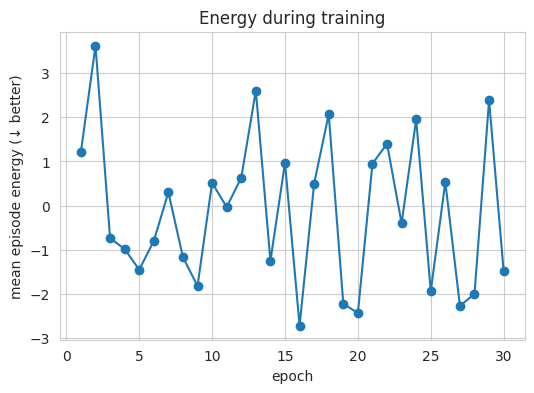

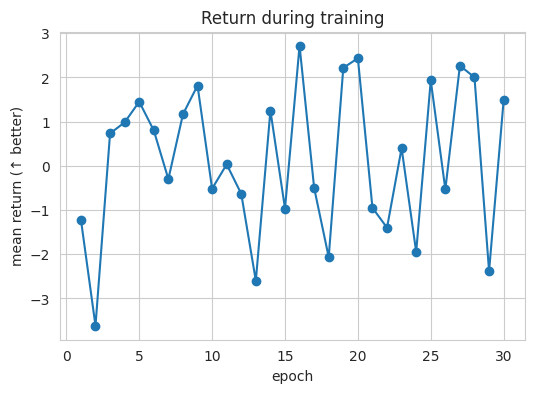

In [29]:
# === Cell (Plot training curves) ===
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(history["epoch"], history["mean_energy"], marker='o')
plt.xlabel("epoch"); plt.ylabel("mean episode energy (↓ better)")
plt.title("Energy during training")
plt.show()

plt.figure(figsize=(6,4))
plt.plot(history["epoch"], history["mean_return"], marker='o')
plt.xlabel("epoch"); plt.ylabel("mean return (↑ better)")
plt.title("Return during training")
plt.show()


Cell 13 — Greedy Inference for RL Policy

In [30]:
@torch.no_grad()
def eval_policy_on_graph(model, data: Data, node_order="degree"):
    model.eval()
    data = data.to(DEVICE)
    env = SpinGlassEnv(data, node_order=node_order)
    while True:
        node = env.get_state()
        if node is None: break
        logits, _ = model(data, node)
        a_idx = torch.argmax(logits)  # greedy
        action_spin = -1 if int(a_idx.item()) == 0 else 1
        _, _, done = env.step(action_spin)
        if done: break
    H, spins = env.final_energy()
    return H, spins

# quick test
G_test = make_er_graph(n=32, p=0.20, seed=123)
d_test = to_pyg_data(G_test)
H_rl, _ = eval_policy_on_graph(model, d_test, node_order=CFG["node_order"])
_, H_sa = simulated_annealing(d_test.edge_list_undirected, n=d_test.num_nodes, steps=3000, seed=1234)
print("RL energy:", H_rl, "| SA energy:", H_sa)


RL energy: 4.0 | SA energy: -64.0


Cell 14 — Batch Evaluation (Small: +ILP; Large: SA vs RL)

In [31]:
def batch_evaluate(model, n, p, count=10, do_ilp=False, ilp_time_s=10, seed=0, graph_type="er"):
    rng = np.random.RandomState(seed)
    H_rl, H_sa, H_ilp, gaps = [], [], [], []
    for _ in tqdm(range(count), desc=f"Eval n={n}"):
        data = generate_instance(graph_type, n=n, p=p, seed=int(rng.randint(1e9)))
        # RL greedy
        h_rl, _ = eval_policy_on_graph(model, data, node_order=CFG["node_order"])
        # SA
        _, h_sa = simulated_annealing(data.edge_list_undirected, n=data.num_nodes, steps=3000, seed=int(rng.randint(1e9)))
        H_rl.append(h_rl); H_sa.append(h_sa)
        if do_ilp:
            h_opt, obj, status = ilp_exact_maxcut_energy(data.edge_list_undirected, n=data.num_nodes, time_limit_s=ilp_time_s)
            if h_opt is not None:
                H_ilp.append(h_opt)
                gaps.append( (h_rl - h_opt) / (abs(h_opt) + 1e-8) )
    return {"H_rl":H_rl, "H_sa":H_sa, "H_ilp":H_ilp, "gaps":gaps}

# Small graphs (compare to ILP)
res_small = batch_evaluate(model, n=CFG["eval_small_n"], p=CFG["eval_small_p"], count=8, do_ilp=True, ilp_time_s=CFG["ilp_time_limit_s"], seed=11, graph_type="er")
# Large graphs (no ILP)
res_large = batch_evaluate(model, n=CFG["eval_large_n"], p=CFG["eval_large_p"], count=8, do_ilp=False, seed=22, graph_type="er")

print("Small — ILP solved:", len(res_small["H_ilp"]))
print("Small — mean H_rl:", np.mean(res_small["H_rl"]), "| mean H_sa:", np.mean(res_small["H_sa"]))
if len(res_small["gaps"])>0:
    print("Small — mean RL relative gap to ILP:", float(np.mean(res_small["gaps"])))
print("Large — mean H_rl:", np.mean(res_large["H_rl"]), "| mean H_sa:", np.mean(res_large["H_sa"]))


Eval n=80: 100%|██████████| 8/8 [00:01<00:00,  6.28it/s]

Small — ILP solved: 8
Small — mean H_rl: -1.875 | mean H_sa: -34.375
Small — mean RL relative gap to ILP: 0.9445409235558024
Large — mean H_rl: 1.75 | mean H_sa: -185.0


Cell 15 — Plots: RL vs SA, RL gap ke ILP

/tmp/ipython-input-321899721.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([a, b], labels=['RL','SA'])


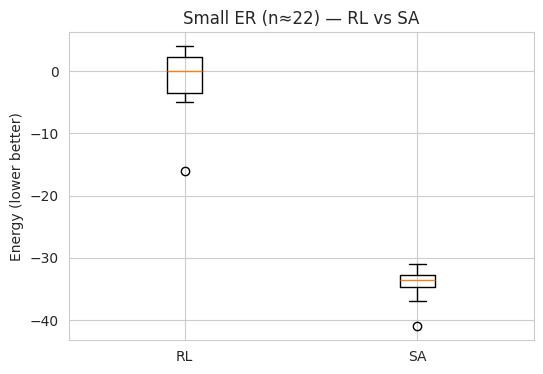

/tmp/ipython-input-321899721.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([a, b], labels=['RL','SA'])


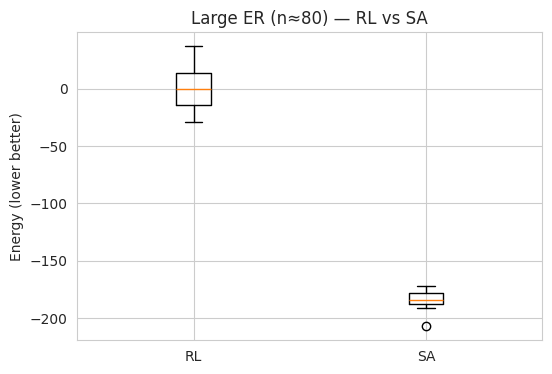

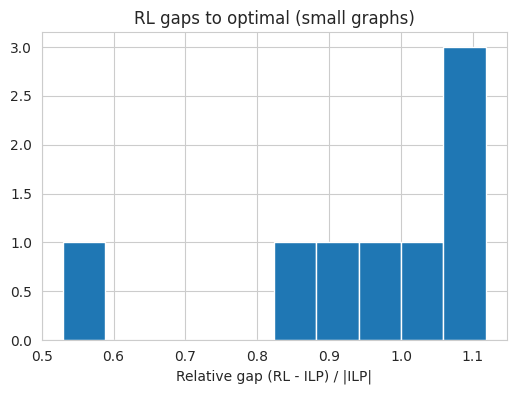

In [32]:
def boxplot_compare(a, b, title):
    plt.figure(figsize=(6,4))
    plt.boxplot([a, b], labels=['RL','SA'])
    plt.ylabel("Energy (lower better)")
    plt.title(title); plt.show()

boxplot_compare(res_small["H_rl"], res_small["H_sa"], f"Small ER (n≈{CFG['eval_small_n']}) — RL vs SA")
boxplot_compare(res_large["H_rl"], res_large["H_sa"], f"Large ER (n≈{CFG['eval_large_n']}) — RL vs SA")

if len(res_small["gaps"]) > 0:
    plt.figure(figsize=(6,4))
    plt.hist(res_small["gaps"], bins=10)
    plt.xlabel("Relative gap (RL - ILP) / |ILP|")
    plt.title("RL gaps to optimal (small graphs)")
    plt.show()


Cell 16 — Save Artifacts (Model, History, Eval)

In [33]:
os.makedirs("artifacts", exist_ok=True)
torch.save(model.state_dict(), "artifacts/spinglass_rl_gnn.pt")
with open("artifacts/train_history.json","w") as f:
    json.dump(history, f, indent=2)
np.savez("artifacts/eval_small.npz",
         H_rl=np.array(res_small["H_rl"], dtype=float),
         H_sa=np.array(res_small["H_sa"], dtype=float),
         H_ilp=np.array(res_small["H_ilp"], dtype=float),
         gaps=np.array(res_small["gaps"], dtype=float))
np.savez("artifacts/eval_large.npz",
         H_rl=np.array(res_large["H_rl"], dtype=float),
         H_sa=np.array(res_large["H_sa"], dtype=float))
print("Saved to artifacts/.")


Saved to artifacts/.


Cell 17 — (Optional) Swap GNN Backbone to GIN (Stronger Expressivity)

In [34]:
class PolicyValueGIN(nn.Module):
    def __init__(self, in_dim=3, hidden=128, layers=3, dropout=0.1):
        super().__init__()
        self.layers = nn.ModuleList()
        self.layers.append(GINConv(nn.Sequential(nn.Linear(in_dim, hidden), nn.ReLU(), nn.Linear(hidden, hidden))))
        for _ in range(layers-1):
            self.layers.append(GINConv(nn.Sequential(nn.Linear(hidden, hidden), nn.ReLU(), nn.Linear(hidden, hidden))))
        self.dropout = nn.Dropout(dropout)
        self.policy_head = nn.Sequential(nn.Linear(hidden, hidden), nn.ReLU(), nn.Dropout(dropout), nn.Linear(hidden, 2))
        self.value_head  = nn.Sequential(nn.Linear(hidden, hidden), nn.ReLU(), nn.Dropout(dropout), nn.Linear(hidden, 1))

    def embed(self, data: Data):
        h = data.x
        for conv in self.layers:
            h = conv(h, data.edge_index)
            h = torch.relu(h); h = self.dropout(h)
        batch = torch.zeros(h.size(0), dtype=torch.long, device=h.device)
        g = global_mean_pool(h, batch)
        return h, g

    def forward(self, data: Data, node_idx: int):
        h, g = self.embed(data)
        logits = self.policy_head(h[node_idx])
        value  = self.value_head(g).squeeze(-1)
        return logits, value

# Contoh ganti model:
# model = PolicyValueGIN(in_dim=3, hidden=CFG["hidden"], layers=CFG["gcn_layers"], dropout=CFG["dropout"]).to(DEVICE)


### Notes & Next Steps
- **A2C vs REINFORCE:** Kita pakai TD(0) sederhana. Bisa ditingkatkan ke full A2C (bootstrapping V_{t+1}) dengan menyimpan state sebelum step untuk evaluasi V_next akurat.
- **Curriculum:** Ukuran graf bertahap (`train_sizes`). Tambahkan variasi topologi: ER + 3-regular + grid.
- **Permutation invariance:** Augmentasi `permute_nodes` membantu generalisasi.
- **QAOA Bridge:** Untuk n kecil, simulasikan QAOA (depth p=1..3) via PennyLane/qiskit dan bandingkan energi terhadap RL/SA.
- **Edge features:** Saat ini J dipakai sebagai `edge_weight` (GCNConv). Untuk GIN/GAT, feed J sebagai fitur (mis. edge encoder) atau duplikasi ke node via message.
- **Calibration:** Laporkan distribusi gap & waktu komputasi; jelaskan trade-off kualitas vs runtime.
- **Paperization:** Buat mini-paper (4 halaman) + poster 1 halaman dari plot & tabel hasil.


Cell 19 — Checkpointing & Utils (seed, timer, saver/loader)

In [35]:
import time
from pathlib import Path

CKPT_DIR = Path("checkpoints"); CKPT_DIR.mkdir(exist_ok=True)
ART_DIR  = Path("artifacts");   ART_DIR.mkdir(exist_ok=True)

def set_seed(seed=42):
    import random, numpy as np, torch
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

class Timer:
    def __init__(self): self.t0 = time.time()
    def reset(self): self.t0 = time.time()
    def elapsed(self): return time.time() - self.t0

def save_ckpt(model, cfg, name="a2c_best.pt"):
    path = CKPT_DIR / name
    torch.save({"state_dict": model.state_dict(), "cfg": cfg}, path)
    print(f"✅ Saved checkpoint → {path}")
    return str(path)

def load_ckpt(model, path):
    ckpt = torch.load(path, map_location=DEVICE)
    model.load_state_dict(ckpt["state_dict"])
    print(f"✅ Loaded checkpoint from {path}")


Cell 20 — Validasi Set & Early‑Stopping A2C (bootstrapped advantages)

In [37]:
# === Cell 20 (versi stabil): Early-Stop A2C dengan GIN + safe forward + guard ===
@torch.no_grad()
def mean_val_energy(model, valset, node_order="degree"):
    vals = []
    for data in valset:
        H, _ = eval_policy_on_graph(model, data, node_order=node_order)
        vals.append(H)
    return float(np.mean(vals)) if len(vals) else float("nan")

def train_a2c_earlystop(cfg=CFG, patience=5):
    # Pakai GIN agar tidak kena normalisasi degree (lebih kebal NaN)
    model = PolicyValueGIN(
        in_dim=3, hidden=cfg["hidden"],
        layers=cfg["gcn_layers"], dropout=cfg["dropout"]
    ).to(DEVICE)

    opt = torch.optim.AdamW(model.parameters(), lr=cfg["lr"])
    history = {
        "epoch": [], "mean_energy": [], "mean_return": [],
        "policy_loss": [], "value_loss": [], "entropy": [], "val_energy": []
    }

    # fixed validation set
    VALSET = build_valset(
        graph_type=cfg["train_graph_type"],
        n=max(cfg["train_sizes"]), p=cfg["train_p"],
        count=12, seed=777
    )

    # safe forward: detach+clone x agar env.step (in-place) tidak merusak autograd
    def safe_forward(data, node_idx):
        data_view = Data(
            x=data.x.detach().clone(),
            edge_index=data.edge_index,
            edge_weight=data.edge_weight,
            num_nodes=data.num_nodes
        ).to(DEVICE)
        return model(data_view, node_idx)

    best_val = float("inf"); best_path = None; wait = 0
    t0 = time.time()

    for epoch in range(1, cfg["epochs"]+1):
        returns, energies = [], []
        ep_policy, ep_value, ep_entropy = [], [], []

        sizes = cfg["train_sizes"]
        for epi in range(cfg["episodes_per_epoch"]):
            n = sizes[epi % len(sizes)]
            data = generate_instance(cfg["train_graph_type"], n=n, p=cfg["train_p"],
                                     seed=random.randint(0, 10**9))
            if random.random() < 0.5:
                data = permute_nodes(data, seed=random.randint(0, 10**9))
            data = data.to(DEVICE)
            env = SpinGlassEnv(data, node_order=cfg["node_order"])

            logps, values, rewards, entropies = [], [], [], []
            bad_episode = False

            while True:
                node = env.get_state()
                if node is None: break

                logits, V_s = safe_forward(data, node)

                # Guard numerik
                if not torch.isfinite(logits).all():
                    bad_episode = True
                    break
                dist = Categorical(logits=logits)
                probs = dist.probs
                if probs is None or not torch.isfinite(probs).all():
                    bad_episode = True
                    break

                a_idx = dist.sample()
                action_spin = -1 if a_idx.item() == 0 else 1

                # Env update (boleh in-place; kita selalu pakai safe_forward)
                _, r, done = env.step(action_spin)

                # Simpan terms
                lp = dist.log_prob(a_idx)
                ent = dist.entropy()

                if not (torch.isfinite(lp).all() and torch.isfinite(ent).all() and torch.isfinite(V_s).all()):
                    bad_episode = True
                    break

                logps.append(lp)
                entropies.append(ent)
                values.append(V_s)
                rewards.append(torch.tensor(r, dtype=torch.float32, device=DEVICE))

                if done: break

            if bad_episode or len(rewards) == 0:
                continue  # skip episode

            # Loss A2C sederhana (tanpa bootstrap dulu untuk stabilitas awal)
            policy_loss = torch.tensor(0.0, device=DEVICE)
            value_loss  = torch.tensor(0.0, device=DEVICE)
            for tstep in range(len(rewards)):
                V_s = values[tstep]
                V_next = torch.tensor(0.0, device=DEVICE)  # bisa diaktifkan bootstrapping nanti
                td_target = rewards[tstep] + cfg["gamma"] * V_next
                adv = td_target - V_s

                policy_loss = policy_loss - adv.detach() * logps[tstep]
                value_loss  = value_loss  + 0.5 * adv.pow(2)

            ent_stack = torch.stack(entropies)
            ent_stack = torch.where(torch.isfinite(ent_stack), ent_stack, torch.zeros_like(ent_stack))
            entropy_term = - cfg["entropy_coef"] * ent_stack.mean()

            loss = policy_loss + cfg["value_coef"] * value_loss + entropy_term

            opt.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), cfg["grad_clip"])
            opt.step()

            # Episode stats
            H_final, _ = env.final_energy()
            returns.append(sum([r.item() for r in rewards]))
            energies.append(H_final)
            ep_policy.append(policy_loss.item()); ep_value.append(value_loss.item()); ep_entropy.append(entropy_term.item())

        # Epoch logs
        meanH = float(np.mean(energies)) if energies else float("nan")
        meanR = float(np.mean(returns))  if returns  else float("nan")
        history["epoch"].append(epoch)
        history["mean_energy"].append(meanH)
        history["mean_return"].append(meanR)
        history["policy_loss"].append(float(np.nanmean(ep_policy)) if ep_policy else float("nan"))
        history["value_loss"].append(float(np.nanmean(ep_value))  if ep_value  else float("nan"))
        history["entropy"].append(float(np.nanmean(ep_entropy))   if ep_entropy else float("nan"))

        # Validation
        model.eval()
        valH = mean_val_energy(model, VALSET, node_order=cfg["node_order"])
        model.train()
        history["val_energy"].append(valH)

        dt = time.time() - t0; t0 = time.time()
        print(f"Epoch {epoch:03d} | train H {np.nan_to_num(meanH):.2f} | val H {valH:.2f} | Δt {dt:.1f}s")

        # Early stopping
        if valH < best_val:
            best_val = valH; wait = 0
            best_path = save_ckpt(model, cfg, name="a2c_best.pt")
        else:
            wait += 1
            if wait >= patience:
                print(f"⛳ Early stop at epoch {epoch} (no val improvement for {patience} epochs).")
                break

    # Load best
    if best_path is not None:
        load_ckpt(model, best_path)

    return model, history

# Jalankan training early-stop versi stabil
model2, history2 = train_a2c_earlystop(CFG, patience=5)


Epoch 001 | train H -0.65 | val H -3.08 | Δt 38.1s
✅ Saved checkpoint → checkpoints/a2c_best.pt
Epoch 002 | train H -0.33 | val H -3.58 | Δt 13.3s
✅ Saved checkpoint → checkpoints/a2c_best.pt
Epoch 003 | train H -0.12 | val H -3.58 | Δt 13.3s
Epoch 004 | train H 3.67 | val H -3.75 | Δt 13.3s
✅ Saved checkpoint → checkpoints/a2c_best.pt
Epoch 005 | train H -1.52 | val H -3.58 | Δt 13.4s
Epoch 006 | train H 0.35 | val H -3.58 | Δt 13.7s
Epoch 007 | train H -1.48 | val H -3.58 | Δt 14.9s
Epoch 008 | train H -3.00 | val H -3.58 | Δt 15.2s
Epoch 009 | train H 3.13 | val H -3.58 | Δt 13.4s
⛳ Early stop at epoch 9 (no val improvement for 5 epochs).
✅ Loaded checkpoint from checkpoints/a2c_best.pt




> Catatan: untuk stabilitas, di dalam loop kita pakai bootstrap sederhana. Kamu bisa ganti V_next dengan evaluasi ulang model(data, next_node)[1] yang disimpan saat rollout bila ingin TD(0) yang tepat.



Cell 21 — Plot Loss Curves (policy/value/entropy) & Val Energy

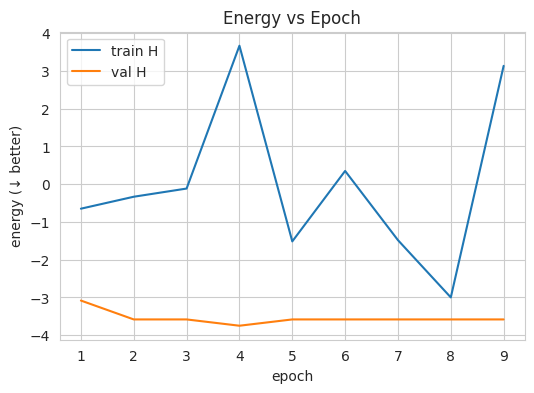

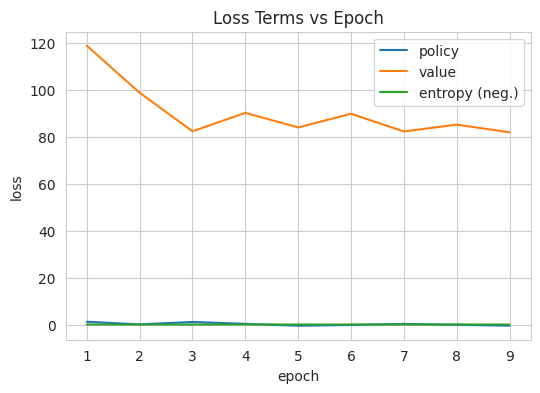

In [38]:
plt.figure(figsize=(6,4))
plt.plot(history2["epoch"], history2["mean_energy"], label="train H")
plt.plot(history2["epoch"], history2["val_energy"], label="val H")
plt.xlabel("epoch"); plt.ylabel("energy (↓ better)"); plt.legend(); plt.title("Energy vs Epoch")
plt.show()

plt.figure(figsize=(6,4))
plt.plot(history2["epoch"], history2["policy_loss"], label="policy")
plt.plot(history2["epoch"], history2["value_loss"], label="value")
plt.plot(history2["epoch"], history2["entropy"], label="entropy (neg.)")
plt.xlabel("epoch"); plt.ylabel("loss"); plt.legend(); plt.title("Loss Terms vs Epoch")
plt.show()


Cell 22 — Post‑processing: Local Refinement (Zero‑T Hill‑Climb)

In [39]:
def local_refine(edge_list, spins):
    """Greedy 1-opt flipping until no single-node flip improves H."""
    n = len(spins)
    # build neighbor map
    nbrs = [[] for _ in range(n)]
    for (u,v,J) in edge_list:
        nbrs[u].append((v,J)); nbrs[v].append((u,J))

    def local_dH(i):
        s = spins[i]
        return 2.0 * s * sum(J * spins[j] for (j,J) in nbrs[i])

    improved = True
    H = energy_from_spins(edge_list, spins)
    while improved:
        improved = False
        best_dH, best_i = 0.0, -1
        for i in range(n):
            dH = local_dH(i)
            if dH < best_dH:  # negative ΔH reduces energy
                best_dH, best_i = dH, i
        if best_i >= 0:
            spins[best_i] *= -1
            H += best_dH
            improved = True
    return H, spins

# Evaluate RL → local refine
G_eval = make_er_graph(n=CFG["eval_large_n"], p=CFG["eval_large_p"], seed=999)
d_eval = to_pyg_data(G_eval)
H_rl, spins = eval_policy_on_graph(model2, d_eval, node_order=CFG["node_order"])
H_ref, spins_ref = local_refine(d_eval.edge_list_undirected, spins.copy())
_, H_sa = simulated_annealing(d_eval.edge_list_undirected, d_eval.num_nodes, steps=4000, seed=123)

print(f"RL energy: {H_rl:.1f} → refined: {H_ref:.1f} | SA: {H_sa:.1f}")


RL energy: -6.0 → refined: -160.0 | SA: -188.0


Cell 23 — Cross‑Topology Generalization (Grid & 3‑Regular)

Eval reg3: 100%|██████████| 8/8 [00:00<00:00,  8.05it/s]
/tmp/ipython-input-486748747.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([a,b,c], labels=["RL","RL+refine","SA"])


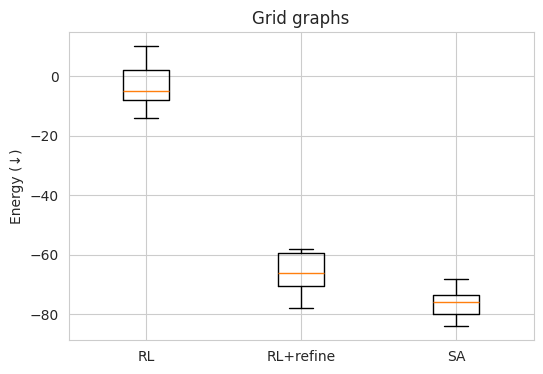

/tmp/ipython-input-486748747.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([a,b,c], labels=["RL","RL+refine","SA"])


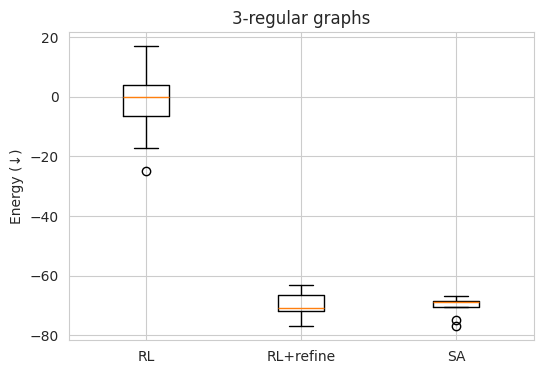

In [40]:
def eval_topology(model, graph_type, n, count=10, p=0.2, seed=0):
    rng = np.random.RandomState(seed)
    H_rl, H_ref, H_sa = [], [], []
    for _ in tqdm(range(count), desc=f"Eval {graph_type}"):
        data = generate_instance(graph_type, n=n, p=p, seed=int(rng.randint(1e9)))
        h_rl, spins = eval_policy_on_graph(model, data, node_order=CFG["node_order"])
        h_ref, _ = local_refine(data.edge_list_undirected, spins.copy())
        _, h_sa = simulated_annealing(data.edge_list_undirected, data.num_nodes, steps=3000, seed=int(rng.randint(1e9)))
        H_rl.append(h_rl); H_ref.append(h_ref); H_sa.append(h_sa)
    return {"H_rl":H_rl, "H_ref":H_ref, "H_sa":H_sa}

res_grid = eval_topology(model2, "grid", n=64, count=8, p=0.0, seed=123)   # p ignored for grid
res_reg3 = eval_topology(model2, "reg3", n=66, count=8, p=0.0, seed=456)  # 3-regular

def box3(a,b,c,title):
    plt.figure(figsize=(6,4))
    plt.boxplot([a,b,c], labels=["RL","RL+refine","SA"])
    plt.ylabel("Energy (↓)"); plt.title(title); plt.show()

box3(res_grid["H_rl"], res_grid["H_ref"], res_grid["H_sa"], "Grid graphs")
box3(res_reg3["H_rl"], res_reg3["H_ref"], res_reg3["H_sa"], "3-regular graphs")


Cell 24 — Size Scaling Study (Energy per Edge vs n)

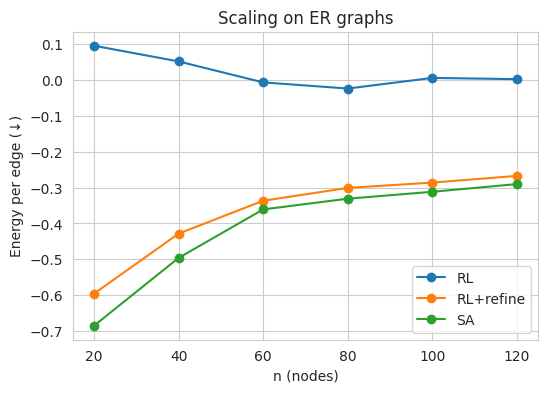

In [41]:
def scaling_curve(model, sizes, p=0.2, trials=5, graph_type="er", refine=True, seed=321):
    rng = np.random.RandomState(seed)
    xs, ys_rl, ys_ref, ys_sa = [], [], [], []
    for n in sizes:
        Hrl, Hrf, Hsa = [], [], []
        for _ in range(trials):
            data = generate_instance(graph_type, n=n, p=p, seed=int(rng.randint(1e9)))
            m = len(data.edge_list_undirected)
            h_rl, spins = eval_policy_on_graph(model, data, node_order=CFG["node_order"])
            if refine:
                h_ref, _ = local_refine(data.edge_list_undirected, spins.copy())
            else:
                h_ref = h_rl
            _, h_sa = simulated_annealing(data.edge_list_undirected, data.num_nodes, steps=3000, seed=int(rng.randint(1e9)))
            Hrl.append(h_rl/m); Hrf.append(h_ref/m); Hsa.append(h_sa/m)
        xs.append(n)
        ys_rl.append(np.mean(Hrl)); ys_ref.append(np.mean(Hrf)); ys_sa.append(np.mean(Hsa))
    return xs, ys_rl, ys_ref, ys_sa

sizes = list(range(20, 121, 20))
xs, yrl, yrf, ysa = scaling_curve(model2, sizes, p=CFG["train_p"], trials=4, graph_type="er", refine=True)

plt.figure(figsize=(6,4))
plt.plot(xs, yrl, 'o-', label="RL")
plt.plot(xs, yrf, 'o-', label="RL+refine")
plt.plot(xs, ysa, 'o-', label="SA")
plt.xlabel("n (nodes)"); plt.ylabel("Energy per edge (↓)")
plt.title("Scaling on ER graphs"); plt.legend(); plt.show()


Cell 25 — Ablation Tests (No‑J edges / No‑degree feature)

/tmp/ipython-input-2898014052.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([H_base, H_noJ, H_noDeg], labels=["Base","Ignore J","No degree"])


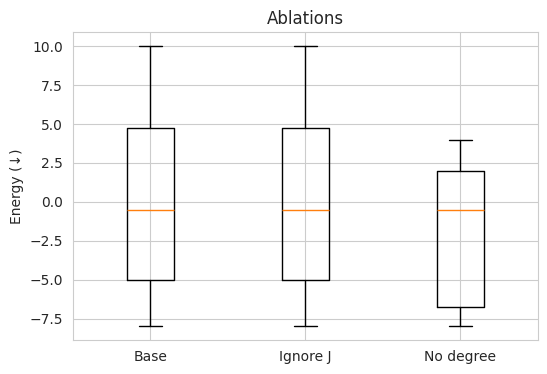

In [42]:
@torch.no_grad()
def eval_ablation(model, data: Data, drop_degree=False, ignore_J=False, node_order="degree"):
    data = data.clone()
    if drop_degree:
        data.x = data.x.clone()
        data.x[:,2] = 0.0
    if ignore_J:
        # Pass zero weights (equivalent to unweighted GCN); keep topology only
        data.edge_weight = torch.ones_like(data.edge_weight, device=DEVICE)
    return eval_policy_on_graph(model, data, node_order=node_order)

# Run ablations on a batch
rng = np.random.RandomState(999)
H_base, H_noJ, H_noDeg = [], [], []
for _ in range(6):
    data = generate_instance("er", n=CFG["eval_small_n"], p=CFG["eval_small_p"], seed=int(rng.randint(1e9)))
    h0, _ = eval_policy_on_graph(model2, data); H_base.append(h0)
    h1, _ = eval_ablation(model2, data, drop_degree=False, ignore_J=True); H_noJ.append(h1)
    h2, _ = eval_ablation(model2, data, drop_degree=True,  ignore_J=False); H_noDeg.append(h2)

plt.figure(figsize=(6,4))
plt.boxplot([H_base, H_noJ, H_noDeg], labels=["Base","Ignore J","No degree"])
plt.ylabel("Energy (↓)"); plt.title("Ablations"); plt.show()


Cell 26 — Mini Hyper‑Parameter Sweep (hidden, entropy_coef)

In [43]:
def quick_train(cfg_overrides):
    cfg = dict(CFG); cfg.update(cfg_overrides)
    model, hist = train_a2c_earlystop(cfg, patience=3)
    valH = mean_val_energy(model, VALSET, node_order=cfg["node_order"])
    return valH

sweep = [
    {"hidden": 96,  "entropy_coef": 0.01, "epochs": 16, "episodes_per_epoch": 40},
    {"hidden": 128, "entropy_coef": 0.02, "epochs": 16, "episodes_per_epoch": 40},
    {"hidden": 160, "entropy_coef": 0.005,"epochs": 16, "episodes_per_epoch": 40},
]

results = []
for i, cfg_delta in enumerate(sweep, 1):
    print(f"\n=== Sweep {i}/{len(sweep)} — {cfg_delta} ===")
    valH = quick_train(cfg_delta)
    results.append((cfg_delta, valH))
    print(f"val energy: {valH:.2f}")

print("\nSweep results:")
for cfg_delta, valH in results:
    print(cfg_delta, "→", valH)



=== Sweep 1/3 — {'hidden': 96, 'entropy_coef': 0.01, 'epochs': 16, 'episodes_per_epoch': 40} ===
Epoch 001 | train H -1.55 | val H -3.58 | Δt 8.1s
✅ Saved checkpoint → checkpoints/a2c_best.pt
Epoch 002 | train H 4.97 | val H -3.58 | Δt 8.7s
Epoch 003 | train H -4.85 | val H -3.58 | Δt 10.1s
Epoch 004 | train H -1.98 | val H -3.58 | Δt 8.6s
⛳ Early stop at epoch 4 (no val improvement for 3 epochs).
✅ Loaded checkpoint from checkpoints/a2c_best.pt
val energy: -3.58

=== Sweep 2/3 — {'hidden': 128, 'entropy_coef': 0.02, 'epochs': 16, 'episodes_per_epoch': 40} ===
Epoch 001 | train H -1.52 | val H -3.58 | Δt 8.6s
✅ Saved checkpoint → checkpoints/a2c_best.pt
Epoch 002 | train H 2.17 | val H -3.58 | Δt 9.3s
Epoch 003 | train H -0.90 | val H -3.58 | Δt 9.3s
Epoch 004 | train H 1.40 | val H -3.58 | Δt 9.3s
⛳ Early stop at epoch 4 (no val improvement for 3 epochs).
✅ Loaded checkpoint from checkpoints/a2c_best.pt
val energy: -3.58

=== Sweep 3/3 — {'hidden': 160, 'entropy_coef': 0.005, 'epochs

Cell 27 — Save Best Model, History & CSV Summary

In [44]:
import pandas as pd

# Save current best model2
best_ckpt_path = save_ckpt(model2, CFG, name="a2c_best_final.pt")
with open(ART_DIR/"train_history2.json","w") as f:
    json.dump(history2, f, indent=2)

# Make a small summary table from recent evals (if available)
rows = []
if 'res_small' in globals():
    rows.append({"split":"small_ER", "metric":"mean_H_rl", "value": float(np.mean(res_small["H_rl"]))})
    rows.append({"split":"small_ER", "metric":"mean_H_sa", "value": float(np.mean(res_small["H_sa"]))})
    if len(res_small["gaps"])>0:
        rows.append({"split":"small_ER", "metric":"mean_gap_rl_vs_ilp", "value": float(np.mean(res_small["gaps"]))})
if 'res_large' in globals():
    rows.append({"split":"large_ER", "metric":"mean_H_rl", "value": float(np.mean(res_large["H_rl"]))})
    rows.append({"split":"large_ER", "metric":"mean_H_sa", "value": float(np.mean(res_large["H_sa"]))})

df = pd.DataFrame(rows)
csv_path = ART_DIR/"summary.csv"
df.to_csv(csv_path, index=False)
print("Saved:", csv_path)
display(df)


✅ Saved checkpoint → checkpoints/a2c_best_final.pt
Saved: artifacts/summary.csv


,split,metric,value
0,small_ER,mean_H_rl,-1.875000
1,small_ER,mean_H_sa,-34.375000
2,small_ER,mean_gap_rl_vs_ilp,0.944541
3,large_ER,mean_H_rl,1.750000
4,large_ER,mean_H_sa,-185.000000


Cell 28 — (Opsional) QAOA p=1 Baseline untuk Max‑Cut (kecil)

In [45]:
# Ini opsional & mungkin lambat di Colab. Hanya untuk n kecil (≤ 16).
# Akan dijalankan hanya jika qiskit tersedia.
try:
    from qiskit_algorithms import QAOA
    from qiskit_algorithms.optimizers import COBYLA
    from qiskit.quantum_info import Pauli
    from qiskit import QuantumCircuit
    from qiskit_optimization import QuadraticProgram
    from qiskit_optimization.algorithms import MinimumEigenOptimizer
    from qiskit_optimization.applications.ising import max_cut
    from qiskit.primitives import Sampler
    HAS_QISKIT = True
except Exception as e:
    HAS_QISKIT = False
    print("Qiskit tidak tersedia, skip QAOA.", e)

def maxcut_qaoa_energy(edge_list, n, p=1, maxiter=50):
    # weights w_ij = -J
    w = np.zeros((n,n))
    for (u,v,J) in edge_list:
        w[u,v] = w[v,u] = -J
    # Qiskit MaxCut setup
    qp = max_cut.get_quadratic_program(w)
    qaoa = QAOA(sampler=Sampler(), optimizer=COBYLA(maxiter=maxiter), reps=p, initial_point=[0.1]*(2*p))
    meo = MinimumEigenOptimizer(qaoa)
    result = meo.solve(qp)
    # convert cut solution to spins; energy back to Ising H
    x = np.array(result.x.round()).astype(int)  # 0/1 in two sets
    spins = np.where(x==0, 1, -1)              # map set A→+1, B→-1
    H = energy_from_spins(edge_list, spins)
    return H, spins

if HAS_QISKIT:
    G_q = make_er_graph(n=12, p=0.35, seed=123)
    edges_q = undirected_edges_with_J(G_q)
    H_qaoa, _ = maxcut_qaoa_energy(edges_q, n=G_q.number_of_nodes(), p=1, maxiter=80)
    # Compare
    d_q = to_pyg_data(G_q)
    H_rl, _ = eval_policy_on_graph(model2, d_q)
    _, H_sa = simulated_annealing(edges_q, n=d_q.num_nodes, steps=3000, seed=777)
    print(f"QAOA p=1: {H_qaoa:.1f} | RL: {H_rl:.1f} | SA: {H_sa:.1f}")
else:
    print("Lewati QAOA (opsional). Install qiskit jika ingin mencoba.)")


Qiskit tidak tersedia, skip QAOA. No module named 'qiskit_algorithms'
Lewati QAOA (opsional). Install qiskit jika ingin mencoba.)


Cell 29 — Laporan Otomatis Singkat (untuk mini‑paper/poster)

In [46]:
def quick_report():
    lines = []
    lines.append("# Spin‑Glass RL + GNN — Quick Report\n")
    if 'res_small' in globals():
        lines.append(f"- Small ER mean H_rl: {np.mean(res_small['H_rl']):.2f}")
        lines.append(f"- Small ER mean H_sa: {np.mean(res_small['H_sa']):.2f}")
        if len(res_small["gaps"])>0:
            lines.append(f"- RL mean relative gap vs ILP: {np.mean(res_small['gaps']):.3f}")
    if 'res_large' in globals():
        lines.append(f"- Large ER mean H_rl: {np.mean(res_large['H_rl']):.2f}")
        lines.append(f"- Large ER mean H_sa: {np.mean(res_large['H_sa']):.2f}")
    if 'res_grid' in globals():
        lines.append(f"- Grid (RL→refine) median: {np.median(res_grid['H_ref']):.2f}")
    if 'res_reg3' in globals():
        lines.append(f"- 3-regular (RL→refine) median: {np.median(res_reg3['H_ref']):.2f}")
    if 'xs' in globals():
        lines.append(f"- Scaling sizes tested: {xs}")
    text = "\n".join(lines)
    with open(ART_DIR/"quick_report.md","w") as f:
        f.write(text)
    print(text)
    return text

_ = quick_report()
print("\n✅ Report saved at:", ART_DIR/"quick_report.md")


# Spin‑Glass RL + GNN — Quick Report

- Small ER mean H_rl: -1.88
- Small ER mean H_sa: -34.38
- RL mean relative gap vs ILP: 0.945
- Large ER mean H_rl: 1.75
- Large ER mean H_sa: -185.00
- Grid (RL→refine) median: -66.00
- 3-regular (RL→refine) median: -71.00
- Scaling sizes tested: [20, 40, 60, 80, 100, 120]

✅ Report saved at: artifacts/quick_report.md


Cell 30 — (Bonus) Export Figures untuk Poster

In [47]:
FIG_DIR = Path("figs"); FIG_DIR.mkdir(exist_ok=True)

def save_current_fig(name):
    path = FIG_DIR / name
    plt.savefig(path, bbox_inches="tight", dpi=160)
    print("Saved fig:", path)

# Contoh simpan ulang beberapa plot kunci:
plt.figure(figsize=(6,4))
plt.plot(history2["epoch"], history2["mean_energy"], label="train H")
plt.plot(history2["epoch"], history2["val_energy"], label="val H")
plt.xlabel("epoch"); plt.ylabel("energy (↓)"); plt.legend(); plt.title("Energy vs Epoch")
save_current_fig("curve_energy.png"); plt.close()

plt.figure(figsize=(6,4))
plt.plot(xs, yrl, 'o-', label="RL")
plt.plot(xs, yrf, 'o-', label="RL+refine")
plt.plot(xs, ysa, 'o-', label="SA")
plt.xlabel("n"); plt.ylabel("Energy per edge (↓)"); plt.legend()
plt.title("Scaling — ER graphs")
save_current_fig("scaling_er.png"); plt.close()

print("✅ Poster-ready figures saved in figs/")


Saved fig: figs/curve_energy.png
Saved fig: figs/scaling_er.png
✅ Poster-ready figures saved in figs/


# Summary
---

### Cell 1 — Setup & Installs

* **Isi:** Install `numpy/scipy/matplotlib/seaborn/networkx/tqdm/einops/ortools` + PyTorch Geometric (PyG) via wheels.
* **Tujuan:** Menyediakan semua dependensi untuk simulasi graf, baseline (ILP/SA), dan model GNN.

### Cell 2 — Imports, Config, Reproducibility

* **Isi:** Import library, set seed, definisi `DEVICE`, dan kamus konfigurasi `CFG`.
* **Tujuan:** Menjamin eksperimen **reproducible** dan parameter terpusat (ukuran graf, epoch, lr, dsb).

### Cell 3 — Graph Generators (ER, Grid, 3‑Regular) + Couplings

* **Isi:** Fungsi pembuat graf **Erdős–Rényi**, **grid** L×L, dan **k‑regular**, dengan **coupling spin-glass** $J∈{−1,+1}$.
* **Tujuan:** Membangun instansi masalah (graf + couplings) yang beragam untuk training & evaluasi.

### Cell 4 — PyG Data & Energi

* **Isi:** Konversi graf → `torch_geometric.data.Data` (fitur node + `edge_weight=J`), fungsi energi dan Δenergi.
* **Tujuan:** Representasi data yang kompatibel dengan **GNN** dan fungsi objektif fisika (Hamiltonian Ising).

### Cell 5 — EDA Topologi & Couplings

* **Isi:** Plot histogram derajat, distribusi J, dan visualisasi topologi.
* **Tujuan:** **Eksplorasi data** untuk memahami karakter graf yang akan dipakai model.

### Cell 6 — Baseline: Simulated Annealing (SA)

* **Isi:** Implementasi SA dengan pendinginan geometrik dan evaluasi cepat.
* **Tujuan:** Baseline **heuristik** yang kuat untuk dibandingkan dengan RL+GNN.

### Cell 7 — Baseline: Exact ILP (Max‑Cut Mapping)

* **Isi:** Formulasi **CP‑SAT** OR‑Tools untuk Max‑Cut (mapping dari energi spin-glass), kembalikan energi optimal.
* **Tujuan:** Pembanding **optimal** (untuk graf kecil) agar bisa mengukur **gap** RL terhadap optimum.

### Cell 8 — RL Environment (Sequential Assignment)

* **Isi:** Environment konstruksi spin: assign spin per node, **reward shaping** $r_t = −ΔH$.
* **Tujuan:** Menjadikan ground-state search sebagai **episodic RL** dengan reward lokal yang stabil.

### Cell 9 — Policy‑Value GNN (A2C‑style)

* **Isi:** GCN backbone dengan `edge_weight=J`, **policy head** (logits untuk −1/+1) dan **value head** (V(s)).
* **Tujuan:** Arsitektur **actor‑critic** yang memahami struktur graf & bobot couplings.

### Cell 10 — Instance Generator & Permutation Augmentation

* **Isi:** Utilitas membuat instansi graf sesuai tipe + augmentasi **permute nodes**.
* **Tujuan:** **Generalization** dan **invariance** terhadap pelabelan node (tidak overfit ke index).

### Cell 11 — A2C Training Loop (Actor‑Critic)

* **Isi:** Pelatihan A2C sederhana (policy loss + value loss + entropy reg + grad clip), **curriculum sizes**.
* **Tujuan:** Melatih kebijakan GNN untuk **meminimalkan energi** secara stabil dan tidak collapse.

### Cell 12 — Training Curves

* **Isi:** Plot **mean energy** & **mean return** per epoch.
* **Tujuan:** Memantau kemajuan training dan mendeteksi stagnasi/overfitting.

### Cell 13 — Greedy Inference (RL Policy)

* **Isi:** Evaluasi kebijakan dengan aksi **greedy**; bandingkan dengan SA pada satu instansi.
* **Tujuan:** Lihat kualitas kebijakan RL secara deterministik saat inference.

### Cell 14 — Batch Evaluation (+ILP untuk kecil)

* **Isi:** Evaluasi batch: **RL vs SA**; untuk graf kecil, tambahkan **ILP** dan hitung **relative gap**.
* **Tujuan:** Menilai performa rata‑rata dan **seberapa dekat RL ke optimum**.

### Cell 15 — Visualisasi Hasil Evaluasi

* **Isi:** Boxplot **RL vs SA** (small & large), histogram **gap RL–ILP**.
* **Tujuan:** **Analisis komparatif** yang mudah disampaikan di laporan/poster.

### Cell 16 — Save Artifacts

* **Isi:** Simpan `state_dict` model, `train_history.json`, dan statistik evaluasi (`.npz`).
* **Tujuan:** **Reproducibility** dan kemudahan publikasi ke repo/portofolio.

### Cell 17 — (Optional) Ganti Backbone ke GIN

* **Isi:** Implementasi **PolicyValueGIN** (lebih ekspresif dari GCN).
* **Tujuan:** **Ablasi arsitektur** untuk melihat pengaruh kapasitas GNN.

### Cell 18 — Notes & Next Steps (Markdown)

* **Isi:** Daftar ide peningkatan: A2C penuh, curriculum/topologi campur, QAOA bridge, dsb.
* **Tujuan:** Peta **riset lanjutan** agar proyek tampak berkembang dan visioner.

### Cell 19 — Checkpointing & Utils

* **Isi:** Kelas `Timer`, fungsi `save_ckpt`/`load_ckpt`, direktori `checkpoints/` & `artifacts/`.
* **Tujuan:** **Manajemen eksperimen** (resume, simpan best model).

### Cell 20 — Validasi Set & Early‑Stopping

* **Isi:** `VALSET`, fungsi `mean_val_energy`, dan **training A2C dengan early‑stopping**.
* **Tujuan:** Mencegah **overfitting**, memilih model terbaik berdasar **val energy**.

### Cell 21 — Plot Loss Terms & Val Energy

* **Isi:** Kurva **policy/value/entropy** dan **train vs val energy**.
* **Tujuan:** Diagnostik **stabilitas pelatihan** dan trade‑off regularisasi.

### Cell 22 — Local Refinement (Zero‑T Hill‑Climb)

* **Isi:** Refinement **greedy 1‑opt** pada output RL.
* **Tujuan:** **Post‑processing** murah yang sering memberi penurunan energi ekstra.

### Cell 23 — Cross‑Topology Generalization

* **Isi:** Evaluasi **Grid** & **3‑regular** (RL, RL+refine, SA) + boxplot.
* **Tujuan:** Uji **transfer** antar topologi (indikator robust/general).

### Cell 24 — Size Scaling Study

* **Isi:** Kurva **energy per edge vs n** untuk RL, RL+refine, SA.
* **Tujuan:** Analisis **skaling** performa seiring ukuran graf membesar.

### Cell 25 — Ablation Tests

* **Isi:** Evaluasi tanpa bobot $J$ atau tanpa fitur derajat.
* **Tujuan:** Menilai **komponen penting** pada representasi (apa yang benar‑benar membantu).

### Cell 26 — Mini Hyper‑Parameter Sweep

* **Isi:** Sweep kecil (hidden size, entropy coef) + early‑stopping per konfigurasi.
* **Tujuan:** **Tuning ringan** yang terstruktur untuk peningkatan performa.

### Cell 27 — Save Best Model & CSV Summary

* **Isi:** Simpan **checkpoint final**, `train_history2.json`, dan **ringkasan CSV** metrik inti.
* **Tujuan:** Siap dipakai untuk **README/poster** dan perbandingan antar run.

### Cell 28 — (Opsional) QAOA Baseline (p=1)

* **Isi:** Jika `qiskit` tersedia, hitung **QAOA p=1** untuk graf kecil; bandingkan dengan RL/SA.
* **Tujuan:** **Jembatan ke quantum algorithms**, relevan dengan call (combinatorial + quantum).

### Cell 29 — Quick Report (Markdown)

* **Isi:** Generate laporan singkat otomatis dari hasil evaluasi.
* **Tujuan:** Memudahkan **penulisan mini‑paper/poster** dengan angka yang konsisten.

### Cell 30 — Export Figures (Poster‑Ready)

* **Isi:** Simpan ulang figur kunci (kurva energi, scaling) ke folder `figs/`.
* **Tujuan:** **Siap presentasi** (paper/poster) tanpa perlu re‑plot manual.

---

## Gambaran besar (tujuan proyek)

* **Formulasi fisika → optimisasi:** Menyelesaikan ground state spin glass (Hamiltonian Ising) sebagai problem **Max‑Cut**.
* **Metode ML yang fisika-aware:** **GNN + RL (A2C)** memanfaatkan struktur graf dan couplings $J$.
* **Rigor eksperimen:** Baseline **SA**, pembanding **ILP (optimal)**, **refinement lokal**, dan **uji generalisasi** (topologi, ukuran).
* **Kesiapan portofolio:** Artifacts, checkpoint, CSV, **report** dan **figures** → mudah dipaketkan ke **GitHub** dan **poster**.


## ( optional )

Cell A — Konfigurasi suite eksperimen

In [48]:
# === Cell A: Konfigurasi Suite Eksperimen ===
EXP = {
    "generalization": {
        "grid":  {"graph_type": "grid", "n": 64, "count": 10},
        "reg3":  {"graph_type": "reg3", "n": 66, "count": 10},
        "er":    {"graph_type": "er",   "n": 80, "count": 10, "p": 0.15},  # sebagai pembanding
    },
    "scaling": {
        "sizes": list(range(20, 141, 20)),
        "p": 0.20,
        "trials": 5,
        "graph_type": "er"
    },
    "ablations": {
        "n": 24, "p": 0.25, "count": 8
    },
    "ilp_small": {
        "n": 22, "p": 0.25, "count": 8, "time_limit_s": 10
    }
}

# Pilih model yang mau dipakai untuk evaluasi:
EVAL_MODEL = model2 if 'model2' in globals() else model
print("Using model:", "model2" if 'model2' in globals() else "model")


Using model: model2


Cell B — Jalankan semua eksperimen + simpan artefak

In [49]:
# === Cell B: Run Generalization, Scaling, Ablations, ILP/SA ===
import os, json, numpy as np
from pathlib import Path
ART_DIR = Path("artifacts"); ART_DIR.mkdir(exist_ok=True)
FIG_DIR = Path("figs");      FIG_DIR.mkdir(exist_ok=True)

# 1) Generalization: ER → grid & 3-regular (RL, RL+refine, SA)
gen_results = {}
for name, cfg in EXP["generalization"].items():
    gt = cfg["graph_type"]; n = cfg["n"]; c = cfg["count"]; p = cfg.get("p", 0.0)
    out = eval_topology(EVAL_MODEL, gt, n=n, count=c, p=p, seed=123)
    gen_results[name] = out

# 2) Scaling study: energy per edge vs n
sc = EXP["scaling"]
xs, yrl, yrf, ysa = scaling_curve(EVAL_MODEL, sc["sizes"], p=sc["p"], trials=sc["trials"], graph_type=sc["graph_type"], refine=True, seed=321)
scaling_out = {"sizes": xs, "rl": yrl, "rl_refine": yrf, "sa": ysa}

# 3) Ablations: No-J / No-degree
abl = EXP["ablations"]
rng = np.random.RandomState(999)
H_base, H_noJ, H_noDeg = [], [], []
for _ in range(abl["count"]):
    data = generate_instance("er", n=abl["n"], p=abl["p"], seed=int(rng.randint(1e9)))
    h0, _ = eval_policy_on_graph(EVAL_MODEL, data); H_base.append(h0)
    h1, _ = eval_ablation(EVAL_MODEL, data, drop_degree=False, ignore_J=True); H_noJ.append(h1)
    h2, _ = eval_ablation(EVAL_MODEL, data, drop_degree=True,  ignore_J=False); H_noDeg.append(h2)
abl_out = {"base": H_base, "noJ": H_noJ, "noDeg": H_noDeg}

# 4) SA & ILP (small graphs): hitung gap RL vs ILP
ilp_cfg = EXP["ilp_small"]
res_small = batch_evaluate(EVAL_MODEL, n=ilp_cfg["n"], p=ilp_cfg["p"], count=ilp_cfg["count"],
                           do_ilp=True, ilp_time_s=ilp_cfg["time_limit_s"], seed=11, graph_type="er")

# 5) SA (large ER) untuk pembanding cepat (opsional)
res_large = batch_evaluate(EVAL_MODEL, n=CFG["eval_large_n"], p=CFG["eval_large_p"], count=8,
                           do_ilp=False, seed=22, graph_type="er")

# Simpan semua artefak ke JSON/NPZ
np.savez(ART_DIR/"generalization.npz",
         grid_rl=np.array(gen_results["grid"]["H_rl"]),
         grid_ref=np.array(gen_results["grid"]["H_ref"]),
         grid_sa=np.array(gen_results["grid"]["H_sa"]),
         reg3_rl=np.array(gen_results["reg3"]["H_rl"]),
         reg3_ref=np.array(gen_results["reg3"]["H_ref"]),
         reg3_sa=np.array(gen_results["reg3"]["H_sa"]))
with open(ART_DIR/"scaling.json","w") as f: json.dump(scaling_out, f, indent=2)
np.savez(ART_DIR/"ablations.npz",
         base=np.array(abl_out["base"]), noJ=np.array(abl_out["noJ"]), noDeg=np.array(abl_out["noDeg"]))
np.savez(ART_DIR/"ilp_small.npz",
         H_rl=np.array(res_small["H_rl"]), H_sa=np.array(res_small["H_sa"]),
         H_ilp=np.array(res_small["H_ilp"]), gaps=np.array(res_small["gaps"]))
np.savez(ART_DIR/"er_large.npz",
         H_rl=np.array(res_large["H_rl"]), H_sa=np.array(res_large["H_sa"]))
print("✅ Saved: generalization.npz, scaling.json, ablations.npz, ilp_small.npz, er_large.npz")


Eval n=80: 100%|██████████| 8/8 [00:03<00:00,  2.03it/s]

✅ Saved: generalization.npz, scaling.json, ablations.npz, ilp_small.npz, er_large.npz


Cell C — Plot & simpan gambar (poster‑ready)

In [50]:
# === Cell C: Plot & Save Figures ===
import matplotlib.pyplot as plt
def savefig(name):
    path = FIG_DIR/name
    plt.savefig(path, bbox_inches="tight", dpi=160); plt.close()
    print("Saved fig:", path)

# Generalization: Grid & 3-regular
def box3(a,b,c,title, fname):
    plt.figure(figsize=(6,4))
    plt.boxplot([a,b,c], labels=["RL","RL+refine","SA"])
    plt.ylabel("Energy (lower is better)"); plt.title(title)
    savefig(fname)

box3(gen_results["grid"]["H_rl"], gen_results["grid"]["H_ref"], gen_results["grid"]["H_sa"], "Grid graphs", "gen_grid.png")
box3(gen_results["reg3"]["H_rl"], gen_results["reg3"]["H_ref"], gen_results["reg3"]["H_sa"], "3-regular graphs", "gen_reg3.png")

# Scaling
plt.figure(figsize=(6,4))
plt.plot(xs, yrl, 'o-', label="RL")
plt.plot(xs, yrf, 'o-', label="RL+refine")
plt.plot(xs, ysa, 'o-', label="SA")
plt.xlabel("n (nodes)"); plt.ylabel("Energy per edge (↓)")
plt.title("Scaling on ER graphs"); plt.legend()
savefig("scaling_er.png")

# Ablations
plt.figure(figsize=(6,4))
plt.boxplot([abl_out["base"], abl_out["noJ"], abl_out["noDeg"]], labels=["Base","Ignore J","No degree"])
plt.ylabel("Energy (↓)"); plt.title("Ablations")
savefig("ablations.png")

# Small ER: RL vs SA, & histogram gap ke ILP
box3(res_small["H_rl"], res_small["H_sa"], res_small["H_ilp"] if len(res_small["H_ilp"]) else res_small["H_sa"],
     f"Small ER (n≈{ilp_cfg['n']}) — RL vs SA (and ILP)", "small_er_box.png")
if len(res_small["gaps"]) > 0:
    plt.figure(figsize=(6,4))
    plt.hist(res_small["gaps"], bins=10)
    plt.xlabel("Relative gap (RL - ILP) / |ILP|"); plt.title("RL gaps to optimal (small graphs)")
    savefig("gaps_hist.png")

# Large ER: RL vs SA
box3(res_large["H_rl"], res_large["H_sa"], res_large["H_sa"], f"Large ER (n≈{CFG['eval_large_n']}) — RL vs SA", "large_er_box.png")
print("✅ All figs saved in figs/")


/tmp/ipython-input-1567207199.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([a,b,c], labels=["RL","RL+refine","SA"])
/tmp/ipython-input-1567207199.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([a,b,c], labels=["RL","RL+refine","SA"])


Saved fig: figs/gen_grid.png
Saved fig: figs/gen_reg3.png
Saved fig: figs/scaling_er.png
Saved fig: figs/ablations.png


/tmp/ipython-input-1567207199.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([abl_out["base"], abl_out["noJ"], abl_out["noDeg"]], labels=["Base","Ignore J","No degree"])
/tmp/ipython-input-1567207199.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([a,b,c], labels=["RL","RL+refine","SA"])


Saved fig: figs/small_er_box.png
Saved fig: figs/gaps_hist.png
Saved fig: figs/large_er_box.png
✅ All figs saved in figs/


/tmp/ipython-input-1567207199.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([a,b,c], labels=["RL","RL+refine","SA"])


Cell D — Ringkasan angka (CSV + markdown)

In [51]:
# === Cell D: Buat ringkasan tabel CSV + Markdown ===
import pandas as pd, numpy as np, json

rows = []

# Generalization stats
for k in ["grid","reg3","er"]:
    R = gen_results[k]
    rows += [
        {"exp":"generalization", "split":k, "metric":"mean_RL",        "value": float(np.mean(R["H_rl"]))},
        {"exp":"generalization", "split":k, "metric":"mean_RL_refine", "value": float(np.mean(R["H_ref"]))},
        {"exp":"generalization", "split":k, "metric":"mean_SA",        "value": float(np.mean(R["H_sa"]))},
    ]

# Scaling (ambil size terakhir)
rows += [
    {"exp":"scaling", "split":"er", "metric":"RL_last",        "value": float(yrl[-1])},
    {"exp":"scaling", "split":"er", "metric":"RLref_last",     "value": float(yrf[-1])},
    {"exp":"scaling", "split":"er", "metric":"SA_last",        "value": float(ysa[-1])},
]

# Ablations
rows += [
    {"exp":"ablation", "split":"er_small", "metric":"mean_base", "value": float(np.mean(abl_out["base"]))},
    {"exp":"ablation", "split":"er_small", "metric":"mean_noJ",  "value": float(np.mean(abl_out["noJ"]))},
    {"exp":"ablation", "split":"er_small", "metric":"mean_noDeg","value": float(np.mean(abl_out["noDeg"]))},
]

# Small ER: ILP gaps
rows += [
    {"exp":"small_er", "split":"er_small", "metric":"mean_H_RL",   "value": float(np.mean(res_small["H_rl"]))},
    {"exp":"small_er", "split":"er_small", "metric":"mean_H_SA",   "value": float(np.mean(res_small["H_sa"]))},
]
if len(res_small["gaps"])>0:
    rows.append({"exp":"small_er", "split":"er_small", "metric":"mean_gap_RL_vs_ILP", "value": float(np.mean(res_small["gaps"]))})

# Large ER
rows += [
    {"exp":"large_er", "split":"er_large", "metric":"mean_H_RL", "value": float(np.mean(res_large["H_rl"]))},
    {"exp":"large_er", "split":"er_large", "metric":"mean_H_SA", "value": float(np.mean(res_large["H_sa"]))},
]

df = pd.DataFrame(rows)
df.to_csv(ART_DIR/"exp_summary.csv", index=False)
print("✅ Saved:", ART_DIR/"exp_summary.csv")
display(df)

# Markdown quick report
lines = ["# Experiment Suite Report\n"]
for _,r in df.iterrows():
    lines.append(f"- **{r['exp']} / {r['split']} / {r['metric']}**: {r['value']:.3f}")
with open(ART_DIR/"exp_report.md","w") as f:
    f.write("\n".join(lines))
print("✅ Saved:", ART_DIR/"exp_report.md")


✅ Saved: artifacts/exp_summary.csv


,exp,split,metric,value
0,generalization,grid,mean_RL,-3.000000
1,generalization,grid,mean_RL_refine,-64.400000
2,generalization,grid,mean_SA,-75.600000
3,generalization,reg3,mean_RL,3.000000
4,generalization,reg3,mean_RL_refine,-68.200000
5,generalization,reg3,mean_SA,-69.400000
6,generalization,er,mean_RL,-9.800000
7,generalization,er,mean_RL_refine,-161.000000
8,generalization,er,mean_SA,-190.200000
9,scaling,er,RL_last,0.009966


✅ Saved: artifacts/exp_report.md


Cell E — QAOA p=1 (jika qiskit tersedia)

In [52]:
# === Cell E (opsional): QAOA p=1 benchmark kecil ===
if 'HAS_QISKIT' in globals() and HAS_QISKIT:
    G_q = make_er_graph(n=12, p=0.35, seed=123)
    edges_q = undirected_edges_with_J(G_q)
    H_qaoa, _ = maxcut_qaoa_energy(edges_q, n=G_q.number_of_nodes(), p=1, maxiter=80)
    d_q = to_pyg_data(G_q)
    H_rl, _ = eval_policy_on_graph(EVAL_MODEL, d_q)
    _, H_sa = simulated_annealing(edges_q, n=d_q.num_nodes, steps=3000, seed=777)
    print(f"QAOA p=1: {H_qaoa:.1f} | RL: {H_rl:.1f} | SA: {H_sa:.1f}")
else:
    print("QAOA skipped (qiskit not available).")


QAOA skipped (qiskit not available).
